In [ ]:
import numpy as np
import pandas as pd

np.random.seed(27)

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.__version__)

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

Num GPUs Available:  1
2.11.0


# Set up OpenAQ, Meteostat APIs

OpenAQ: https://openaq.org/
MeteoStat: https://meteostat.net/en

Tools
py-openaq: https://github.com/dhhagan/py-openaq
meteostat: https://dev.meteostat.net/python/

In [ ]:
pip install py-openaq

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for py-openaq: filename=py_openaq-1.1.0-py3-none-any.whl size=9037 sha256=7efd44085b55ef231bccb44145774236a9aea107fc27d8d78a08ed01a2ddf3cc
  Stored in directory: /root/.cache/pip/wheels/b0/87/d2/6824c8ea805b5ed5de4993b7d728b490d98d6b51abc54ddaf1
Successfully built py-openaq


In [ ]:
import openaq
!pip install meteostat
# Import Meteostat library and dependencies
from meteostat import Point, Hourly, Daily

openaq = openaq.OpenAQ(version="v2")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Get data from OpenAQ

In [ ]:

class Location:
    def __init__(self, name, lat, lon):
        self.name = name
        self.lat = lat
        self.lon = lon


locations_IT = []

cities = openaq.cities(country="GB", limit=100000, df=True)["city"]

for city in cities:
    print(city) 
    try:
        res = openaq.locations(city=city, df=True)[["coordinates.latitude","coordinates.longitude"]].mean()
    
        locations_IT.append(Location(city, res["coordinates.latitude"], res["coordinates.longitude"]))
    except:
        print("-----------Skipped {}-----------".format(city))

Aberdeen
Adur
Armagh
Aston Hill
Auchencorth
Ballymena
Barking and Dagenham
Barnsley
Barnstaple
Bath
Belfast
Bexley
Billingham
Birmingham
Blackburn
Blackpool
Bottesford
Bournemouth
Bradford
Brent
Brighton
Brighton and Hove
Bristol
Bromley
Bury
Bush Estate
Cambridge
Camden
Canterbury
Cardiff
Carlisle
Central Scotland
Charlton
Chatham
Chepstow
Chesterfield
Chichester
City of London
Coventry
Crawley
Crompton Way   OL2 8AQ
Croydon
Dartford
Derby
Derry
Doncaster
Dumbarton
Dumfries
Ealing
Eastbourne
Edinburgh
Enfield
Eskdalemuir
Exeter
Fort William
Glasgow
Glazebury
Grangemouth
Great Dun Fell
Greenwich
Hackney
Hampshire
Haringey
Harrow
Hastings
Havering
High Muffles
Honiton
Horley
Horsham
Hull
Inverness
Islington
Kingston
Ladybower
Lambeth
Leamington Spa
Leeds
Leicester
Leominster
Lerwick
Lewes
Lewisham
Lincoln
Liverpool
London
Lough Navar
Lullington Heath
Luton
Mace Head
Manchester
Market Harborough
Merton
Middlesbrough
N/A
Narberth
Newcastle
Newham
Newport
Northampton
North West & Merseysid

In [ ]:
from datetime import datetime, timedelta
import time

# Napoli index 68
# Trento index 113

# Select Napoli because it holds most sensors and less holes
selected_location = locations_IT[85]
print(selected_location.name)
# Format coordinates to align with OpenAQ standards
coordinates = "{},{}".format(round(selected_location.lat, 8), round(selected_location.lon, 8))

now = datetime(2021,10,1)

# For some reason the OpenAQ API accepts the date only in this way
date_from = datetime(2020 , 5, 10)
date_to = datetime(now.year, now.month, now.day) + timedelta(days=1)

print("Time Range: {} - {}".format(date_from, date_to))

selected_pollutants = ['pm25','pm10','no2','o3','so2']

# Create empty Dataframe
df_pollutants = pd.DataFrame(columns=selected_pollutants)

# getPollutants()

for pollutant in selected_pollutants:
    locations = openaq.locations(coordinates=coordinates, parameter=pollutant, radius=20000, df=True, has_geo=True)

    dfs_array = []
    for location in locations["id"]:
        try:
            time.sleep(3)
            df = openaq.measurements(location=location,
                                     date_from=date_from.date(), 
                                     date_to=date_to.date(),
                                     limit=100000, 
                                     parameter=pollutant,
                                     df=True,
                                     sort="asc")[["value"]].resample('H').mean()
            
            dfs_array.append(df)
            print("Added location {}".format(location))
        
        except:
            print("Skipped location {}".format(location))
    
    dfs_array = sorted(dfs_array,key=lambda x:x.index[0])
    df_pollutants[pollutant] = pd.concat(dfs_array, join="outer", axis = 1, sort=False).mean(axis=1)
    print("Added pollutant {}".format(pollutant))
    print("---------------------")

print("Data fetching completed!")

df_pollutants

London
Time Range: 2020-05-10 00:00:00 - 2021-10-02 00:00:00
Skipped location 73049
Skipped location 613094
Skipped location 497264
Skipped location 65995
Added location 158
Added location 152
Added location 147
Added location 155
Added location 159
Added location 154
Added location 148
Added location 146
Skipped location 60
Added location 225725
Added location 225755
Added location 225765
Added location 225766
Added location 225770
Added location 225772
Added location 225797
Added location 225803
Added location 227058
Skipped location 137
Added location 230827
Added location 225832
Added location 225802
Added location 225801
Added location 225787
Skipped location 225767
Added location 225743
Skipped location 225705
Skipped location 225714
Added location 225747
Added location 225751
Added location 225790
Added location 225796
Skipped location 225764
Added location 225723
Added location 225824
Added location 225794
Skipped location 270693
Added location 225737
Added location 225793
Skip

,pm25,pm10,no2,o3,so2
date.local,,,,,
2020-05-10 01:00:00,16.891389,31.833333,31.625000,106.500000,4.333333
2020-05-10 02:00:00,16.564286,32.500000,28.875000,105.666667,4.000000
2020-05-10 03:00:00,16.746571,32.000000,30.250000,101.333333,5.500000
2020-05-10 04:00:00,16.622857,31.250000,26.750000,98.333333,5.500000
2020-05-10 05:00:00,17.446944,30.400000,24.000000,93.500000,4.666667
...,...,...,...,...,...
2021-10-01 21:00:00,7.986957,15.759259,38.663636,30.725000,2.200000
2021-10-01 22:00:00,6.166667,15.637838,35.358333,30.737500,1.975000
2021-10-01 23:00:00,4.000000,11.166667,29.250000,37.000000,2.000000


array([<AxesSubplot:xlabel='date.local'>,
       <AxesSubplot:xlabel='date.local'>,
       <AxesSubplot:xlabel='date.local'>,
       <AxesSubplot:xlabel='date.local'>,
       <AxesSubplot:xlabel='date.local'>], dtype=object)

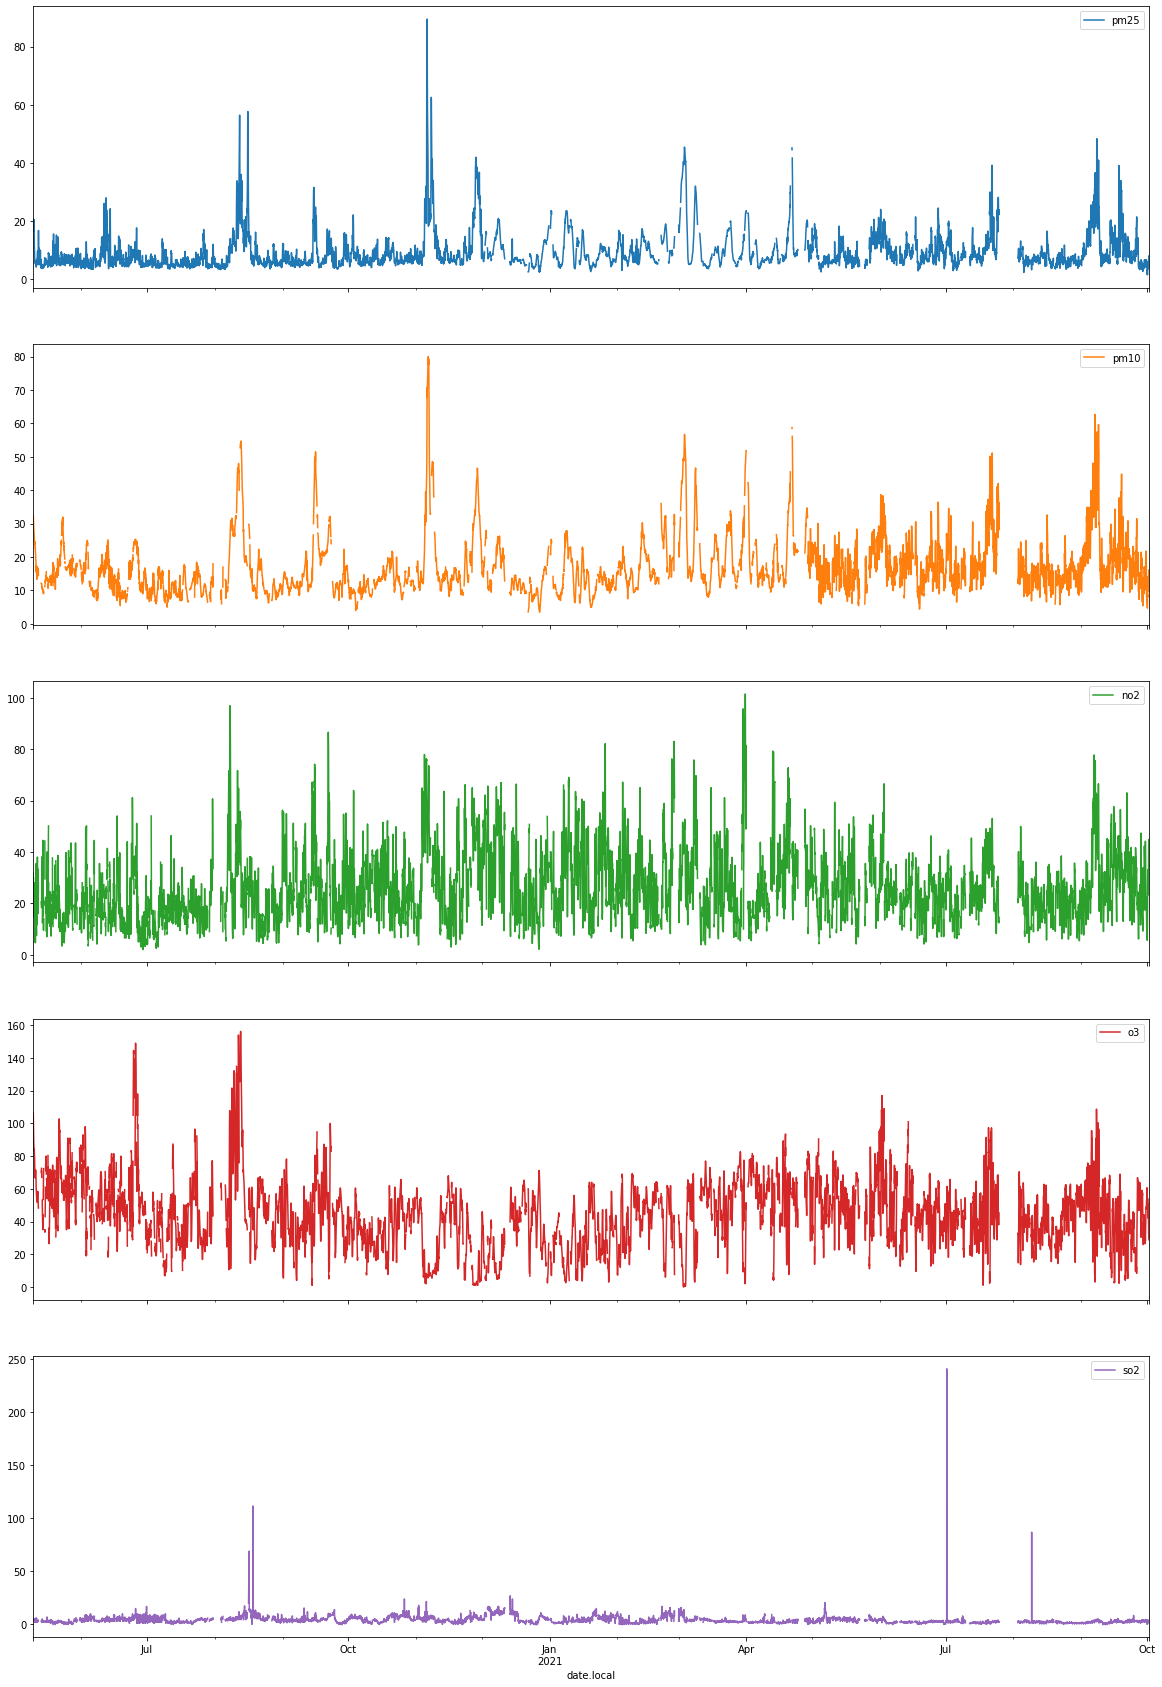

In [ ]:
df_pollutants.plot(figsize=(20,30), subplots=True)

In [ ]:
# Create Point for London
# We will give the median between the maximum: 245m, minimum: 0m elevation of London 

loc = Point(selected_location.lat, selected_location.lon, 72)

# temp  The air temperature in °C
# dwpt  The dew point in °C
# rhum  The relative humidity in percent (%)
# prcp  The one hour precipitation total in mm
# snow  The snow depth in mm
# wdir  The average wind direction in degrees (°)
# wspd  The average wind speed in km/h
# wpgt  The peak wind gust in km/h
# pres  The average sea-level air pressure in hPa
# tsun  The one hour sunshine total in minutes (m)
# coco  The weather condition code

# Get hourly data
df_weather = Hourly(loc=loc, start=date_from, end=date_to)
df_weather = df_weather.normalize()
df_weather = df_weather.fetch()

# Remove columns that hold no values
weather_features = ['dwpt', 'prcp', 'snow', 'wdir', 'wpgt', 'tsun']
df_weather.drop(weather_features, axis=1, inplace=True)
# df_weather = df_weather.interpolate(method='time')

final_df = df_pollutants.merge(df_weather, left_index=True, right_index=True)

final_df

,pm25,pm10,no2,o3,so2,temp,rhum,wspd,pres,coco
2020-05-10 01:00:00,16.891389,31.833333,31.625000,106.500000,4.333333,13.6,63.0,5.4,1007.0,3.0
2020-05-10 02:00:00,16.564286,32.500000,28.875000,105.666667,4.000000,13.6,63.0,5.4,1007.0,3.0
2020-05-10 03:00:00,16.746571,32.000000,30.250000,101.333333,5.500000,12.6,67.0,5.4,1007.0,3.0
2020-05-10 04:00:00,16.622857,31.250000,26.750000,98.333333,5.500000,12.6,72.0,3.6,1006.0,3.0
2020-05-10 05:00:00,17.446944,30.400000,24.000000,93.500000,4.666667,11.6,77.0,1.8,1007.0,3.0
...,...,...,...,...,...,...,...,...,...,...
2021-10-01 20:00:00,7.930435,16.167857,44.270886,29.529412,2.575000,12.6,63.0,13.0,1012.0,2.0
2021-10-01 21:00:00,7.986957,15.759259,38.663636,30.725000,2.200000,11.6,67.0,14.8,1012.0,2.0
2021-10-01 22:00:00,6.166667,15.637838,35.358333,30.737500,1.975000,10.6,71.0,9.4,1012.0,1.0
2021-10-01 23:00:00,4.000000,11.166667,29.250000,37.000000,2.000000,10.6,71.0,7.6,1012.0,1.0


In [ ]:
final_df.to_csv('London.csv')
final_df=pd.read_csv('London.csv')
final_df

## Fill any empty value

In [ ]:
cols_with_Nan = final_df.columns[final_df.isnull().any()].tolist()

if cols_with_Nan:
    for col in cols_with_Nan:
        while(final_df[col].isnull().sum() > 0):
            final_df[col] = final_df[col].fillna(final_df[col].rolling('4D',min_periods=1).mean())
        final_df[col] = final_df[col].interpolate(method='pchip', limit_direction='both')
        
final_df.isnull().sum()

pm25    0
pm10    0
no2     0
o3      0
so2     0
temp    0
rhum    0
wspd    0
pres    0
coco    0
dtype: int64

# Calculate AQI for each pollutant

EEA AQI TABLE

| Key | Category | PM2,5 μg/m³ | PM10 μg/m³ | NO2 ppb | O3 ppb | SO2 ppb
| :- | :- | :- | :- | :- | :- | :- |
| 1 | Good | 0-10 | 0-20 | 0-40 | 0-50 | 0-100 | 
| 2 | Fair | 10-20 | 20-40 | 40-90 | 50-100 | 100-200 | 
| 3 | Moderate | 20-25 | 40-50 | 90-120 | 100-130 | 200-350 | 
| 4 | Poor | 25-50 | 50-100 | 120-230 | 130-240 | 350-500 |
| 5 | Very Poor | 50-75 | 100-150 | 230-340 | 240-380 | 500-750 |
| 6 | Extremely Poor | 75-800 | 150-1200 | 340-1000 | 380-800 | 750-1250 |

We will use key numbers for each category:

Good: 1
Fair: 2
Moderate: 3
Poor: 4
Very Poor: 5
Extremely Poor: 6

### Define functions to calculate AQI for each pollutant

In [ ]:
def calcPM25(x):
    if x <= 10:
        return 1
    elif x >=11 and x <= 20:
        return 2
    elif x >=21 and x <= 25:
        return 3
    elif x >=26 and x <= 50:
        return 4
    elif x >=51 and x <= 75:
        return 5
    elif x >=76:
        return 6
    else:
        return 1
    
def calcPM10(x):
    if x <= 20:
        return 1
    elif x >=21 and x <= 40:
        return 2
    elif x >=41 and x <= 50:
        return 3
    elif x >=51 and x <= 100:
        return 4
    elif x >=101 and x <= 150:
        return 5
    elif x >=151:
        return 6
    else:
        return 1
    
def calcNO2(x):
    if x <= 40:
        return 1
    elif x >=41 and x <= 90:
        return 2
    elif x >=91 and x <= 120:
        return 3
    elif x >=121 and x <= 230:
        return 4
    elif x >=231 and x <= 340:
        return 5
    elif x >=341:
        return 6
    else:
        return 1
    
def calcO3(x):
    if x <= 50:
        return 1
    elif x >=51 and x <= 100:
        return 2
    elif x >=101 and x <= 130:
        return 3
    elif x >=131 and x <= 240:
        return 4
    elif x >=241 and x <= 380:
        return 5
    elif x >=381:
        return 6
    else:
        return 1
    
def calcSO2(x):
    if x <= 100:
        return 1
    elif x >=101 and x <= 200:
        return 2
    elif x >=201 and x <= 350:
        return 3
    elif x >=351 and x <= 500:
        return 4
    elif x >=501 and x <= 750:
        return 5
    elif x >=751:
        return 6
    else:
        return 1
    

    
final_df["pm25_AQI"] = final_df["pm25"].apply(lambda x: calcPM25(x))
final_df["pm10_AQI"] = final_df["pm10"].apply(lambda x: calcPM10(x))
final_df["no2_AQI"] = final_df["no2"].apply(lambda x: calcNO2(x))
final_df["o3_AQI"] = final_df["o3"].apply(lambda x: calcO3(x))
final_df["so2_AQI"] = final_df["so2"].apply(lambda x: calcSO2(x))

Source: https://www.euronews.com/weather/copernicus-air-quality-index

The overall hourly European Air Quality index is simply defined as the highest value of the 5 individual pollutants indexes computed for the same hour. For instance, if the indices relative to O3, NO2, SO2, PM2.5 and PM10 are 1,3,1,2,2 respectively, the overall index will be 3.

In [ ]:
# final_df["overall_AQI"] = max(final_df[["pm25_AQI", "pm10_AQI", "o3_AQI", "so2_AQI", "co_AQI"]])
final_df["overall_AQI"] = final_df[["pm25_AQI","pm10_AQI","no2_AQI","o3_AQI","so2_AQI"]].max(axis=1)

final_df

,pm25,pm10,no2,o3,so2,temp,rhum,wspd,pres,coco,pm25_AQI,pm10_AQI,no2_AQI,o3_AQI,so2_AQI,overall_AQI
2020-05-10 01:00:00,16.891389,31.833333,31.625000,106.500000,4.333333,13.6,63.0,5.4,1007.0,3.0,2,2,1,3,1,3
2020-05-10 02:00:00,16.564286,32.500000,28.875000,105.666667,4.000000,13.6,63.0,5.4,1007.0,3.0,2,2,1,3,1,3
2020-05-10 03:00:00,16.746571,32.000000,30.250000,101.333333,5.500000,12.6,67.0,5.4,1007.0,3.0,2,2,1,3,1,3
2020-05-10 04:00:00,16.622857,31.250000,26.750000,98.333333,5.500000,12.6,72.0,3.6,1006.0,3.0,2,2,1,2,1,2
2020-05-10 05:00:00,17.446944,30.400000,24.000000,93.500000,4.666667,11.6,77.0,1.8,1007.0,3.0,2,2,1,2,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-01 20:00:00,7.930435,16.167857,44.270886,29.529412,2.575000,12.6,63.0,13.0,1012.0,2.0,1,1,2,1,1,2
2021-10-01 21:00:00,7.986957,15.759259,38.663636,30.725000,2.200000,11.6,67.0,14.8,1012.0,2.0,1,1,1,1,1,1
2021-10-01 22:00:00,6.166667,15.637838,35.358333,30.737500,1.975000,10.6,71.0,9.4,1012.0,1.0,1,1,1,1,1,1
2021-10-01 23:00:00,4.000000,11.166667,29.250000,37.000000,2.000000,10.6,71.0,7.6,1012.0,1.0,1,1,1,1,1,1


### Change type of each value for memory performance

In [ ]:
final_df = final_df.astype(np.float32)
final_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12240 entries, 2020-05-10 01:00:00 to 2021-10-02 00:00:00
Freq: H
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   pm25         12240 non-null  float32
 1   pm10         12240 non-null  float32
 2   no2          12240 non-null  float32
 3   o3           12240 non-null  float32
 4   so2          12240 non-null  float32
 5   temp         12240 non-null  float32
 6   rhum         12240 non-null  float32
 7   wspd         12240 non-null  float32
 8   pres         12240 non-null  float32
 9   coco         12240 non-null  float32
 10  pm25_AQI     12240 non-null  float32
 11  pm10_AQI     12240 non-null  float32
 12  no2_AQI      12240 non-null  float32
 13  o3_AQI       12240 non-null  float32
 14  so2_AQI      12240 non-null  float32
 15  overall_AQI  12240 non-null  float32
dtypes: float32(16)
memory usage: 860.6 KB


# Data Correlation

Pandas offers 3 methods of calculating correlation. Pearson, Spearman, Kendall

The Pearson's Correlation Coefficient is also known as the Pearson Product-Moment Correlation Coefficient. It is a measure of the linear relationship between two random variables - X and Y. Mathematically, if (σXY) is the covariance between X and Y, and (σX) is the standard deviation of X, then the Pearson's correlation coefficient ρ is given by:

ρxy = σxy / ( σx * σy )

## Pearson

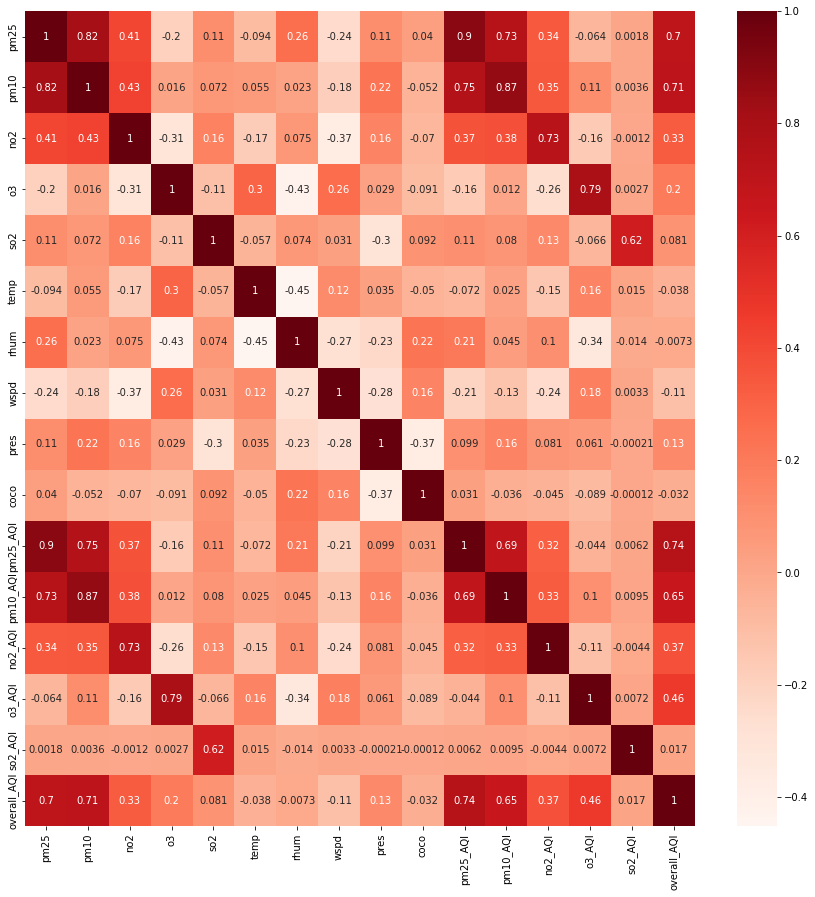

In [ ]:
plt.figure(figsize=(15,15))
cor = final_df.corr(method='pearson')
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

## Spearman's rho

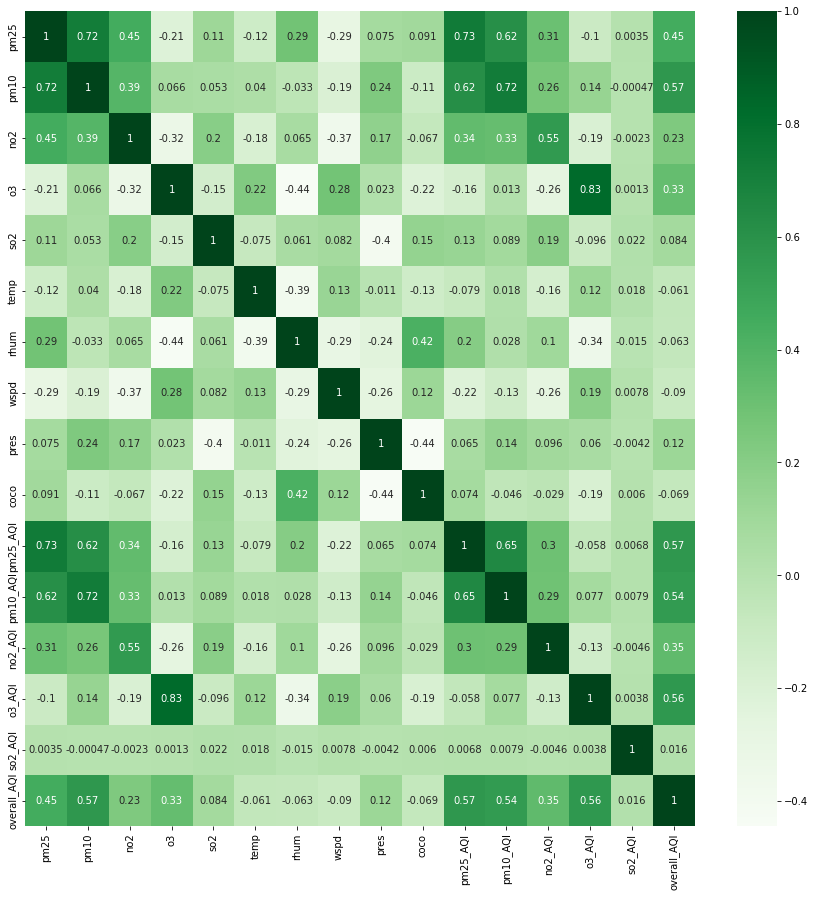

In [ ]:
plt.figure(figsize=(15,15))
cor = final_df.corr(method='spearman')
sns.heatmap(cor, annot=True, cmap=plt.cm.Greens)
plt.show()

## Kendall's  tau

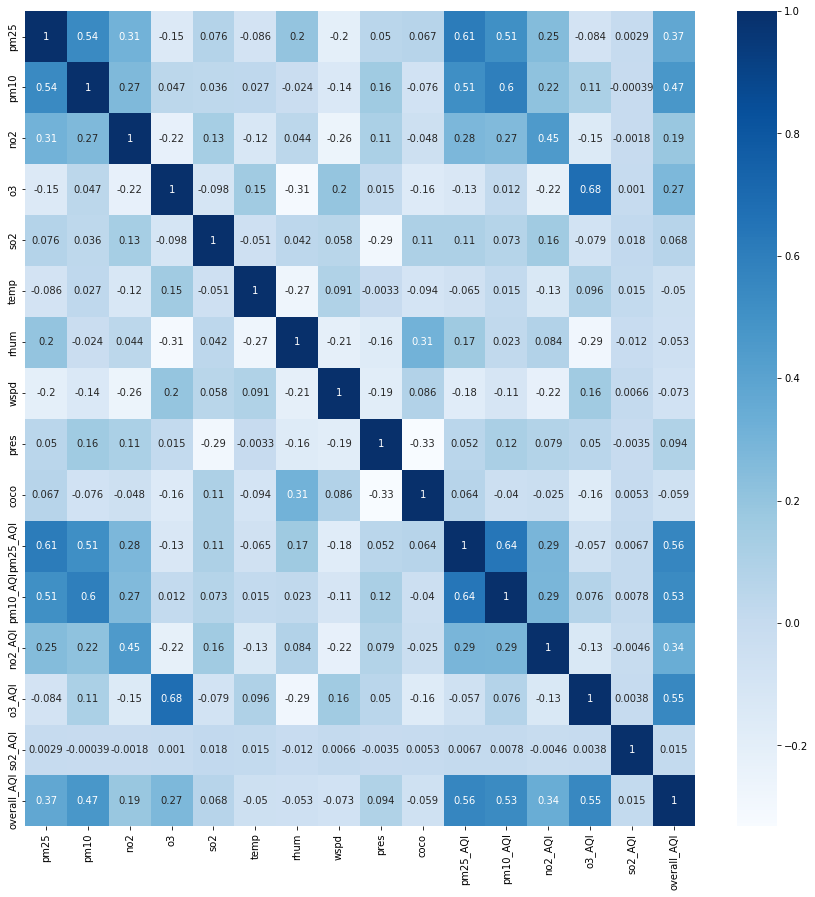

In [ ]:
plt.figure(figsize=(15,15))
cor = final_df.corr(method='kendall')
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues)
plt.show()

# Data Preparation for Machine Learning Models

In [ ]:
final_df.columns

Index(['pm25', 'pm10', 'no2', 'o3', 'so2', 'temp', 'rhum', 'wspd', 'pres',
       'coco', 'pm25_AQI', 'pm10_AQI', 'no2_AQI', 'o3_AQI', 'so2_AQI',
       'overall_AQI'],
      dtype='object')

In [ ]:
dataset = final_df.copy()
dataset

,pm25,pm10,no2,o3,so2,temp,rhum,wspd,pres,coco,pm25_AQI,pm10_AQI,no2_AQI,o3_AQI,so2_AQI,overall_AQI
2020-05-10 01:00:00,16.891388,31.833334,31.625000,106.500000,4.333333,13.6,63.0,5.4,1007.0,3.0,2.0,2.0,1.0,3.0,1.0,3.0
2020-05-10 02:00:00,16.564285,32.500000,28.875000,105.666664,4.000000,13.6,63.0,5.4,1007.0,3.0,2.0,2.0,1.0,3.0,1.0,3.0
2020-05-10 03:00:00,16.746571,32.000000,30.250000,101.333336,5.500000,12.6,67.0,5.4,1007.0,3.0,2.0,2.0,1.0,3.0,1.0,3.0
2020-05-10 04:00:00,16.622858,31.250000,26.750000,98.333336,5.500000,12.6,72.0,3.6,1006.0,3.0,2.0,2.0,1.0,2.0,1.0,2.0
2020-05-10 05:00:00,17.446945,30.400000,24.000000,93.500000,4.666667,11.6,77.0,1.8,1007.0,3.0,2.0,2.0,1.0,2.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-01 20:00:00,7.930435,16.167856,44.270885,29.529411,2.575000,12.6,63.0,13.0,1012.0,2.0,1.0,1.0,2.0,1.0,1.0,2.0
2021-10-01 21:00:00,7.986957,15.759259,38.663635,30.725000,2.200000,11.6,67.0,14.8,1012.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0
2021-10-01 22:00:00,6.166667,15.637837,35.358334,30.737499,1.975000,10.6,71.0,9.4,1012.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2021-10-01 23:00:00,4.000000,11.166667,29.250000,37.000000,2.000000,10.6,71.0,7.6,1012.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


### Split data

In [ ]:
from sklearn.model_selection import train_test_split

features=dataset.values
targets=dataset[["pm25", "pm10", "no2", "o3", "so2"]].values

X_train, X_test, y_train, y_test  = train_test_split(features, targets, test_size=0.1, random_state=1, shuffle=False)

X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.1, random_state=1, shuffle=False)

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)

X_train: (9914, 16)
X_test: (1224, 16)


### Data Normalizaton

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)

X_val = scaler.transform(X_val)

X_test = scaler.transform(X_test)

X_train.shape, X_test.shape

((9914, 16), (1224, 16))

### Set up data with TimeseriesGenerator

In [ ]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

win_length=12
batch_size=4
num_features=features.shape[1]

train_generator = TimeseriesGenerator(X_train, y_train, length=win_length, sampling_rate=1, batch_size=batch_size)
val_generator = TimeseriesGenerator(X_val, y_val, length=win_length, sampling_rate=1, batch_size=batch_size)
test_generator = TimeseriesGenerator(X_test, y_test, length=win_length, sampling_rate=1, batch_size=batch_size)

train_generator[0]

(array([[[0.16647816, 0.3703704 , 0.29790503, 0.6818182 , 0.03880597,
          0.45000002, 0.55421686, 0.108     , 0.5070429 , 0.08      ,
          0.2       , 0.33333334, 0.        , 0.6666666 , 0.        ,
          0.40000004],
         [0.16272038, 0.37908497, 0.2702514 , 0.67648315, 0.0358209 ,
          0.45000002, 0.55421686, 0.108     , 0.5070429 , 0.08      ,
          0.2       , 0.33333334, 0.        , 0.6666666 , 0.        ,
          0.40000004],
         [0.16481449, 0.37254903, 0.2840782 , 0.64874095, 0.04925374,
          0.42500004, 0.6024096 , 0.108     , 0.5070429 , 0.08      ,
          0.2       , 0.33333334, 0.        , 0.6666666 , 0.        ,
          0.40000004],
         [0.16339326, 0.3627451 , 0.24888268, 0.6295348 , 0.04925374,
          0.42500004, 0.6626506 , 0.072     , 0.49295807, 0.08      ,
          0.2       , 0.33333334, 0.        , 0.33333334, 0.        ,
          0.2       ],
         [0.17286044, 0.351634  , 0.22122905, 0.59859157, 0.04179104

### Create LSTM model

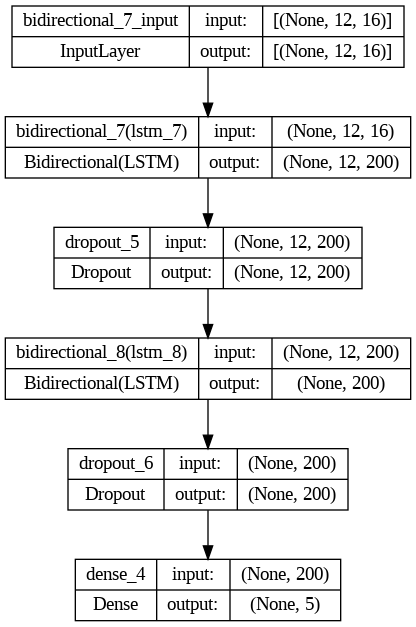

In [ ]:
model_LSTM = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100,  return_sequences=True), input_shape=(win_length, num_features)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=False)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(targets.shape[1])
])

model_LSTM.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss=tf.losses.MeanSquaredLogarithmicError())

tf.keras.utils.plot_model(model=model_LSTM, show_shapes=True)

### Fit model

In [ ]:
lr_monitor = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.5, cooldown=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)

with tf.device('/GPU:0'):
    prepared_model = model_LSTM.fit(train_generator, 
                                    validation_data=val_generator,
                                    epochs=10, 
                                    shuffle=False,  
                                    callbacks=[lr_monitor, early_stopping])

Epoch 1/10
2476/2476 [==============================] - 32s 10ms/step - loss: 0.2882 - val_loss: 0.1711 - lr: 0.0010
Epoch 2/10
2476/2476 [==============================] - 25s 10ms/step - loss: 0.2203 - val_loss: 0.1693 - lr: 0.0010
Epoch 3/10
2476/2476 [==============================] - 24s 10ms/step - loss: 0.1883 - val_loss: 0.1089 - lr: 0.0010
Epoch 4/10
2476/2476 [==============================] - 26s 10ms/step - loss: 0.1525 - val_loss: 0.1014 - lr: 0.0010
Epoch 5/10
2476/2476 [==============================] - 25s 10ms/step - loss: 0.1322 - val_loss: 0.0873 - lr: 0.0010
Epoch 6/10
2476/2476 [==============================] - 25s 10ms/step - loss: 0.1135 - val_loss: 0.0766 - lr: 0.0010
Epoch 7/10
2476/2476 [==============================] - 25s 10ms/step - loss: 0.1032 - val_loss: 0.0649 - lr: 0.0010
Epoch 8/10
2476/2476 [==============================] - 25s 10ms/step - loss: 0.0964 - val_loss: 0.0581 - lr: 0.0010
Epoch 9/10
2476/2476 [==============================] - 25s 10ms

Text(0, 0.5, 'mse score')

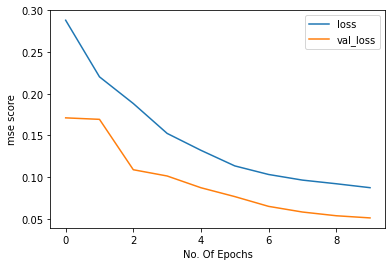

In [ ]:
plt.plot(prepared_model.history["loss"],label="loss")
plt.plot(prepared_model.history["val_loss"],label="val_loss")
plt.legend(loc="best")
plt.xlabel("No. Of Epochs")
plt.ylabel("mse score")

In [ ]:
model_LSTM.evaluate(test_generator, verbose=1)

303/303 [==============================] - 2s 6ms/step - loss: 0.0569


0.056861765682697296

### Get Predictions for new cases

In [ ]:
predictions=model_LSTM.predict(test_generator)

pd.DataFrame(predictions)

303/303 [==============================] - 2s 4ms/step


,0,1,2,3,4
0,6.140231,12.440461,24.268103,34.775906,2.249456
1,6.798916,13.333537,21.871080,35.630978,2.293421
2,6.644433,13.121080,21.298321,37.358765,2.285773
3,6.270567,12.711346,22.234377,39.966679,2.310931
4,6.176805,12.490571,21.617931,39.894115,2.276765
...,...,...,...,...,...
1207,7.387673,16.042866,41.598839,40.319420,3.152368
1208,7.809076,16.601009,43.490604,35.923611,3.242000
1209,8.317535,17.178226,37.071007,36.531673,3.029653
1210,7.665092,15.813324,34.426361,35.955505,2.831155


In [ ]:
df_pred=pd.DataFrame(X_test[:,:][win_length:])

rev_trans=scaler.inverse_transform(df_pred)

df_final=dataset[rev_trans.shape[0]*-1:]
df_final

,pm25,pm10,no2,o3,so2,temp,rhum,wspd,pres,coco,pm25_AQI,pm10_AQI,no2_AQI,o3_AQI,so2_AQI,overall_AQI
2021-08-12 13:00:00,6.330435,14.375439,21.489874,27.362499,2.725000,20.6,73.0,18.4,1018.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0
2021-08-12 14:00:00,6.617391,13.792982,20.693670,28.937500,3.333333,20.6,73.0,20.5,1018.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0
2021-08-12 15:00:00,5.734783,12.836843,20.758228,29.412500,2.650000,21.6,65.0,20.5,1018.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0
2021-08-12 16:00:00,5.813044,12.135715,20.649366,30.531250,2.250000,20.6,69.0,20.5,1018.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0
2021-08-12 17:00:00,5.756522,11.617857,18.348719,31.906250,3.200000,20.6,69.0,14.8,1018.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-01 20:00:00,7.930435,16.167856,44.270885,29.529411,2.575000,12.6,63.0,13.0,1012.0,2.0,1.0,1.0,2.0,1.0,1.0,2.0
2021-10-01 21:00:00,7.986957,15.759259,38.663635,30.725000,2.200000,11.6,67.0,14.8,1012.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0
2021-10-01 22:00:00,6.166667,15.637837,35.358334,30.737499,1.975000,10.6,71.0,9.4,1012.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2021-10-01 23:00:00,4.000000,11.166667,29.250000,37.000000,2.000000,10.6,71.0,7.6,1012.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [ ]:
df_final[["pm25_pred", "pm10_pred", "no2_pred", "o3_pred", "so2_pred"]]=predictions
df_final

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,pm25,pm10,no2,o3,so2,temp,rhum,wspd,pres,coco,...,pm10_AQI,no2_AQI,o3_AQI,so2_AQI,overall_AQI,pm25_pred,pm10_pred,no2_pred,o3_pred,so2_pred
2021-08-12 13:00:00,6.330435,14.375439,21.489874,27.362499,2.725000,20.6,73.0,18.4,1018.0,4.0,...,1.0,1.0,1.0,1.0,1.0,6.140231,12.440461,24.268103,34.775906,2.249456
2021-08-12 14:00:00,6.617391,13.792982,20.693670,28.937500,3.333333,20.6,73.0,20.5,1018.0,4.0,...,1.0,1.0,1.0,1.0,1.0,6.798916,13.333537,21.871080,35.630978,2.293421
2021-08-12 15:00:00,5.734783,12.836843,20.758228,29.412500,2.650000,21.6,65.0,20.5,1018.0,4.0,...,1.0,1.0,1.0,1.0,1.0,6.644433,13.121080,21.298321,37.358765,2.285773
2021-08-12 16:00:00,5.813044,12.135715,20.649366,30.531250,2.250000,20.6,69.0,20.5,1018.0,4.0,...,1.0,1.0,1.0,1.0,1.0,6.270567,12.711346,22.234377,39.966679,2.310931
2021-08-12 17:00:00,5.756522,11.617857,18.348719,31.906250,3.200000,20.6,69.0,14.8,1018.0,3.0,...,1.0,1.0,1.0,1.0,1.0,6.176805,12.490571,21.617931,39.894115,2.276765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-01 20:00:00,7.930435,16.167856,44.270885,29.529411,2.575000,12.6,63.0,13.0,1012.0,2.0,...,1.0,2.0,1.0,1.0,2.0,7.387673,16.042866,41.598839,40.319420,3.152368
2021-10-01 21:00:00,7.986957,15.759259,38.663635,30.725000,2.200000,11.6,67.0,14.8,1012.0,2.0,...,1.0,1.0,1.0,1.0,1.0,7.809076,16.601009,43.490604,35.923611,3.242000
2021-10-01 22:00:00,6.166667,15.637837,35.358334,30.737499,1.975000,10.6,71.0,9.4,1012.0,1.0,...,1.0,1.0,1.0,1.0,1.0,8.317535,17.178226,37.071007,36.531673,3.029653
2021-10-01 23:00:00,4.000000,11.166667,29.250000,37.000000,2.000000,10.6,71.0,7.6,1012.0,1.0,...,1.0,1.0,1.0,1.0,1.0,7.665092,15.813324,34.426361,35.955505,2.831155


In [ ]:
def calcPM25(x):
    if x <= 10:
        return 1
    elif x >=11 and x <= 20:
        return 2
    elif x >=21 and x <= 25:
        return 3
    elif x >=26 and x <= 50:
        return 4
    elif x >=51 and x <= 75:
        return 5
    elif x >=76:
        return 6
    else:
        return 1
    
def calcPM10(x):
    if x <= 20:
        return 1
    elif x >=21 and x <= 40:
        return 2
    elif x >=41 and x <= 50:
        return 3
    elif x >=51 and x <= 100:
        return 4
    elif x >=101 and x <= 150:
        return 5
    elif x >=151:
        return 6
    else:
        return 1
    
def calcNO2(x):
    if x <= 40:
        return 1
    elif x >=41 and x <= 90:
        return 2
    elif x >=91 and x <= 120:
        return 3
    elif x >=121 and x <= 230:
        return 4
    elif x >=231 and x <= 340:
        return 5
    elif x >=341:
        return 6
    else:
        return 1
    
def calcO3(x):
    if x <= 50:
        return 1
    elif x >=51 and x <= 100:
        return 2
    elif x >=101 and x <= 130:
        return 3
    elif x >=131 and x <= 240:
        return 4
    elif x >=241 and x <= 380:
        return 5
    elif x >=381:
        return 6
    else:
        return 1
    
def calcSO2(x):
    if x <= 100:
        return 1
    elif x >=101 and x <= 200:
        return 2
    elif x >=201 and x <= 350:
        return 3
    elif x >=351 and x <= 500:
        return 4
    elif x >=501 and x <= 750:
        return 5
    elif x >=751:
        return 6
    else:
        return 1
    

    
final_df["pm25_AQI_pred"] = final_df["pm25_pred"].apply(lambda x: calcPM25(x))
final_df["pm10_AQI_pred"] = final_df["pm10_pred"].apply(lambda x: calcPM10(x))
final_df["no2_AQI_pred"] = final_df["no2_pred"].apply(lambda x: calcNO2(x))
final_df["o3_AQI_pred"] = final_df["o3_pred"].apply(lambda x: calcO3(x))
final_df["so2_AQI_pred"] = final_df["so2_pred"].apply(lambda x: calcSO2(x))

In [ ]:
final_df["overall_pred_aqi"] = final_df[["pm25_AQI_pred","pm10_AQI_pred","no2_AQI_pred","o3_AQI_pred","so2_AQI_pred"]].max(axis=1)

final_df

<AxesSubplot:>

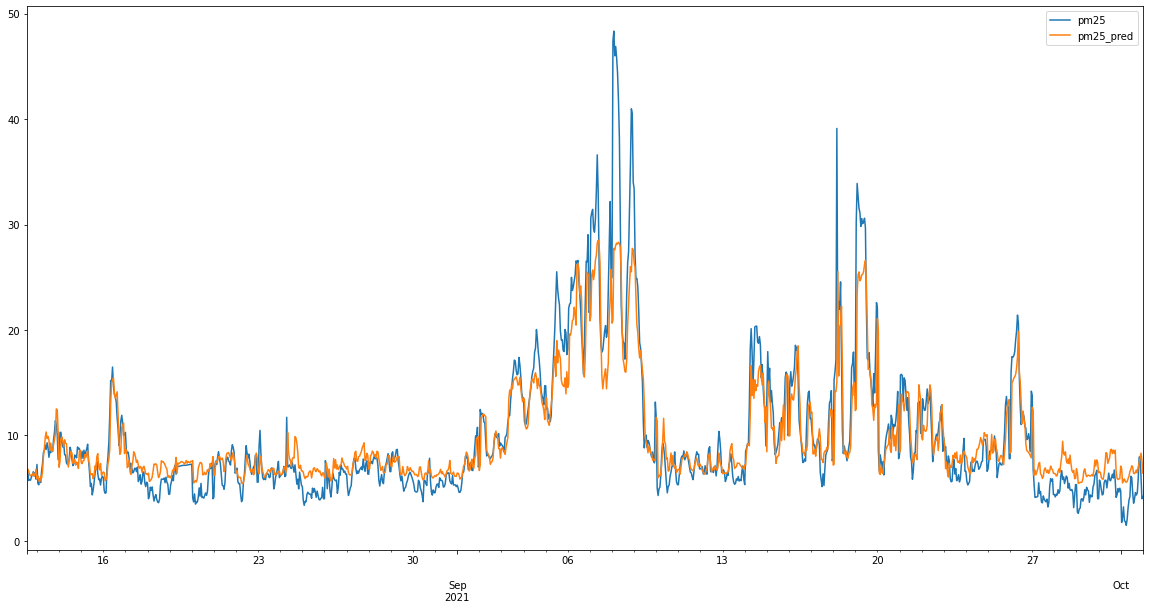

In [ ]:
df_final[["pm25","pm25_pred"]].plot(figsize=(20,10))

<AxesSubplot:>

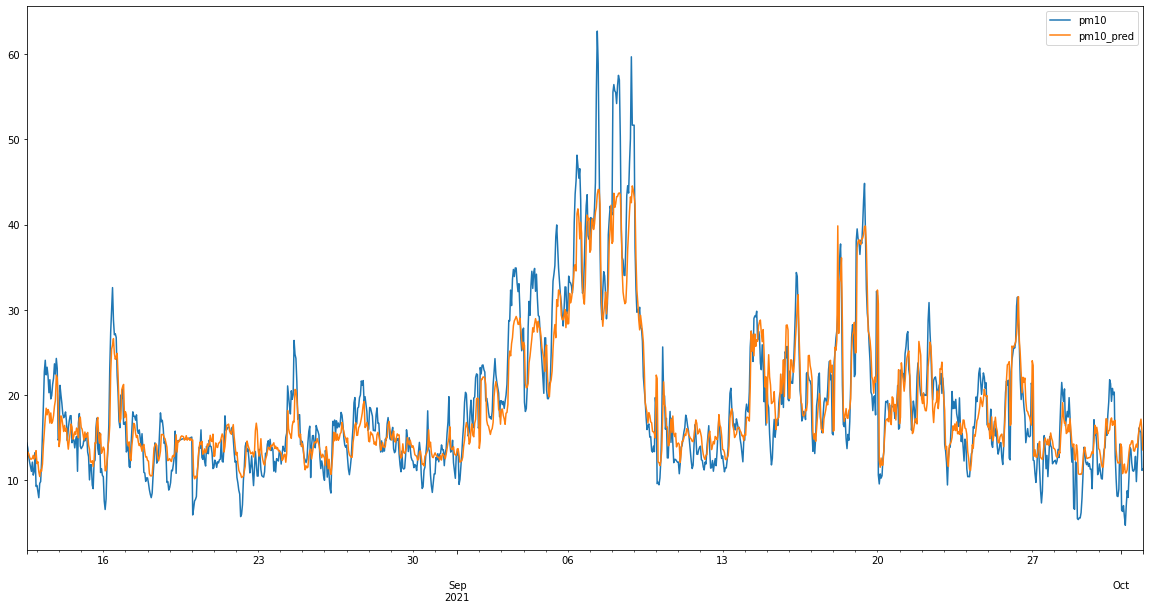

In [ ]:
df_final[["pm10","pm10_pred"]].plot(figsize=(20,10))

<AxesSubplot:>

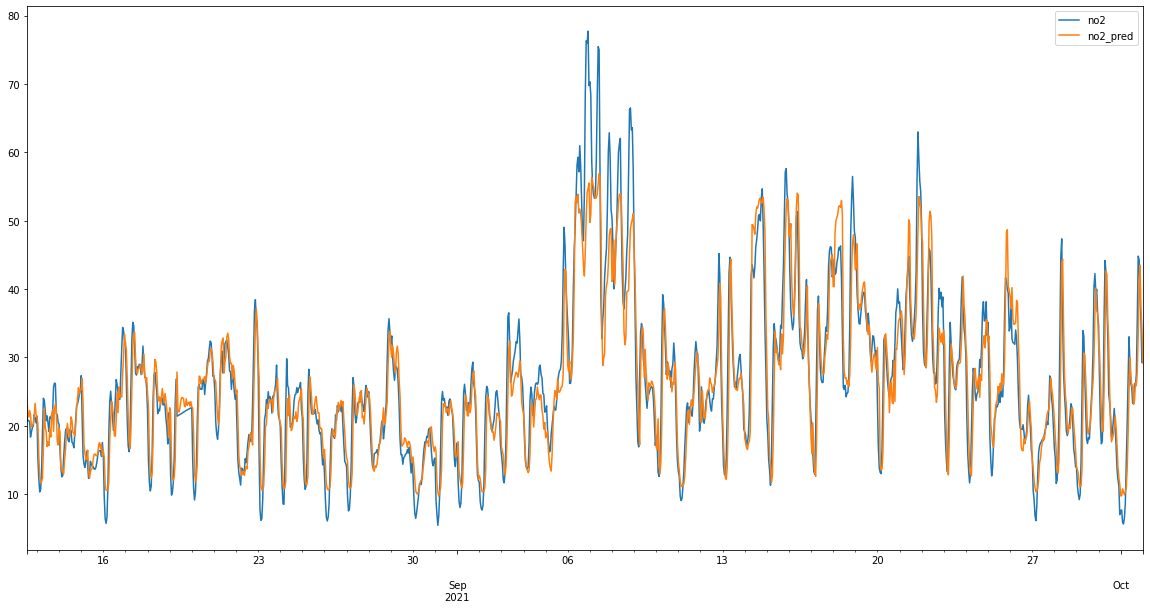

In [ ]:
df_final[["no2","no2_pred"]].plot(figsize=(20,10))

<AxesSubplot:>

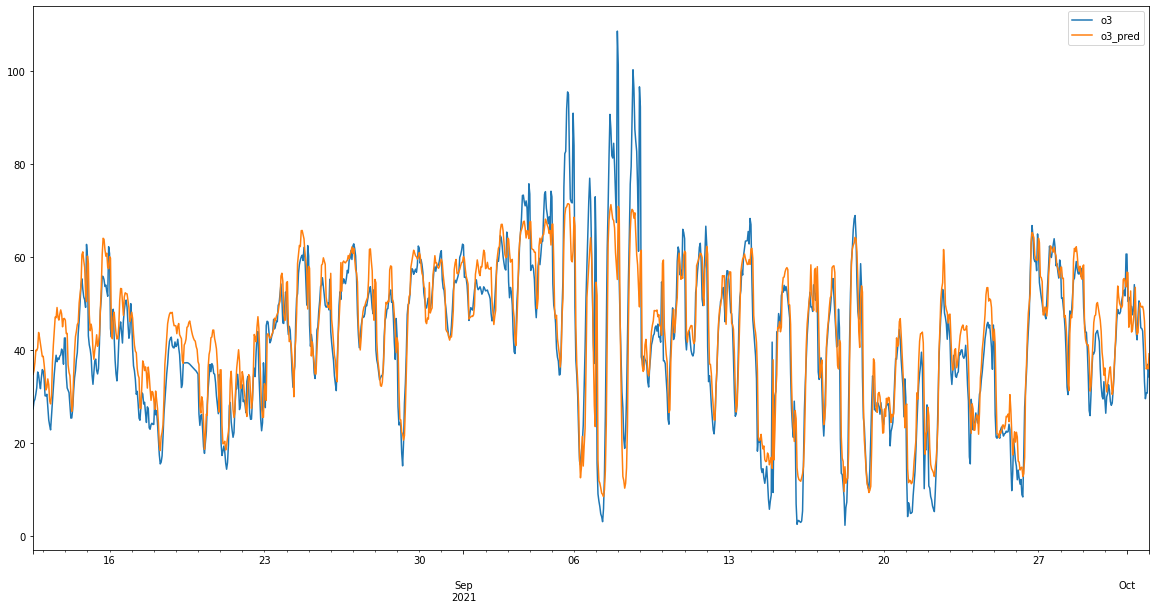

In [ ]:
df_final[["o3","o3_pred"]].plot(figsize=(20,10))

<AxesSubplot:>

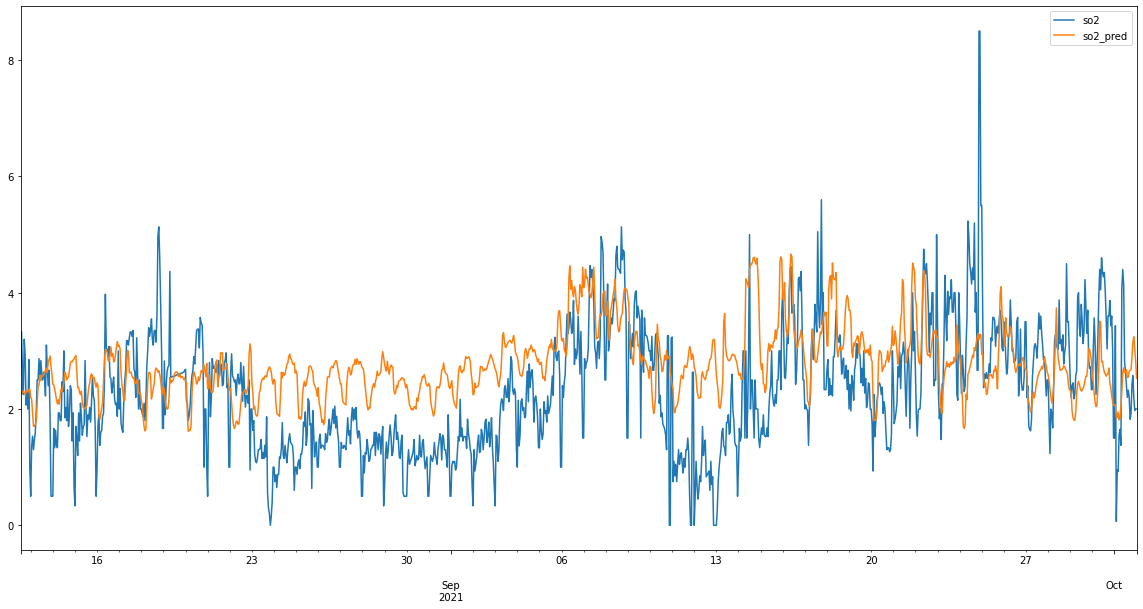

In [ ]:
df_final[["so2","so2_pred"]].plot(figsize=(20,10))

In [ ]:
def evaluate_preds(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    # Calculate various metrics
    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
    mslr = tf.keras.metrics.mean_squared_logarithmic_error(y_true, y_pred)
  
    return {"mae": mae.numpy(),
            "mse": mse.numpy(),
            "rmse": rmse.numpy(),
            "mape": mape.numpy(),
            "mslr": mslr.numpy(),
           }

In [ ]:
selected_features = ["pm25", "pm10", "no2", "o3", "so2"]

for feature in selected_features:
    print("-----{}-----".format(feature))
    print(evaluate_preds(y_true=df_final[feature].values,
                         y_pred=df_final["{}_pred".format(feature)].values)
         )

-----pm25-----
{'mae': 1.7248421, 'mse': 8.059058, 'rmse': 2.8388479, 'mape': 20.366636, 'mslr': 0.04614252}
-----pm10-----
{'mae': 2.4026966, 'mse': 11.223983, 'rmse': 3.3502214, 'mape': 14.363281, 'mslr': 0.02854606}
-----no2-----
{'mae': 3.328722, 'mse': 22.25674, 'rmse': 4.717705, 'mape': 13.90814, 'mslr': 0.03088864}
-----o3-----
{'mae': 5.131244, 'mse': 51.155094, 'rmse': 7.152279, 'mape': 18.26863, 'mslr': 0.05349603}
-----so2-----
{'mae': 0.8821693, 'mse': 1.1703904, 'rmse': 1.0818458, 'mape': 23666382.0, 'mslr': 0.12523554}
